Vamos a usar las implementaciones de Nearest Neighbours de la librería Sklearn, con todas las opciones por defecto salvo las que se discutan en cada punto. Como siempre, hay que implementar código que nos permita seleccionar el k óptimo sobre un conjunto de validación, nos devuelva el clasificador o regresor entrenado, y nos permita hacer curvas de entrenamiento, validación y test en función del número de vecinos.

In [1]:
from base import *
from math import inf
from copy import deepcopy
from sklearn.base import is_classifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn as sk


In [2]:
def medir_error(df: pd.DataFrame, df_entrenado: pd.DataFrame, modelo):
  if is_classifier(modelo):
    return 1 - accuracy_score(df, df_entrenado)
  else:
    return sk.metrics.mean_squared_error(df, df_entrenado)

def model(k, problema):
  switch = {
    'ej1': KNeighborsClassifier(n_neighbors=k, weights='uniform'),
    'ej3': KNeighborsClassifier(n_neighbors=k, weights='distance'),
    'ej4_unif': KNeighborsRegressor(n_neighbors=k, weights='uniform'),
    'ej4_inv': KNeighborsRegressor(n_neighbors=k, weights='distance')
  }

  return switch.get(problema, KNeighborsClassifier(n_neighbors=k, weights='uniform'))

def entrenar(problema, k_values, X_train, y_train, X_val, y_val, X_test, y_test):
  error_train_data = []
  error_val_data = []
  error_test_data = []

  best_error_val = inf

  for k in k_values:
    knn = model(k, problema)
    knn.fit(X_train, y_train)

    train_entrenado = knn.predict(X_train)
    val_entrenado = knn.predict(X_val)
    test_entrenado = knn.predict(X_test)

    current_error_train = medir_error(y_train, train_entrenado, knn)
    current_error_val = medir_error(y_val, val_entrenado, knn)
    current_error_test = medir_error(y_test, test_entrenado, knn)

    error_train_data.append(current_error_train)
    error_val_data.append(current_error_val)
    error_test_data.append(current_error_test)

    if current_error_val < best_error_val:
      best_error_val = current_error_val
      best_k = k
      best_knn = deepcopy(knn)

  return best_k, best_knn, error_train_data, error_val_data, error_test_data

In [3]:
def graph_errores(error_df: pd.DataFrame, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()
    
    plt.plot(df[referencia], df['Error'], linestyle='-')

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)

a) 
- Resuelva el problema de las espirales-anidadas usando k-nn. Utilice el datasets de "espirales con ruido" de esta página. Hay una versión "original" y otra que tiene agregadas dos variables que contienen ruido uniforme. 
- Realice gráficas de las predicciones sobre el conjunto de test, y gráficas de errores vs número de vecinos. 
- Compare el resultado con el obtenido con árboles de decisión, los dos métodos sobre las dos versiones del dataset.

In [4]:
def ej1a_dfs(filename, con_ruido):
  if con_ruido == True:
    names = [0, 1, 2, 3, 'Clase']
    dos_e_dfs = GeneradorDFCSV(filename, custom=True, names=names)
    print("Con ruido")
  else:
    names = [0, 1, "Clase"]
    dos_e_dfs = GeneradorDFCSV(filename)

  df_train_val = dos_e_dfs.df_data #.sample(frac=0.5)
  X_train_val, y_train_val = df_train_val[names[:-1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[names[:-1]], df_test['Clase']

  return X_train, y_train, X_test, y_test, X_val, y_val, df_test

In [5]:
def ej1(filename, con_ruido=False):
  X_train, y_train, X_test, y_test, X_val, y_val, df_test = ej1a_dfs(filename, con_ruido)
  k_values = range(1, 31)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar('ej1', k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  errores = []
  for i in k_values:
    errores.append([error_train_data[i-1], i, "Error train"])
    errores.append([error_val_data[i-1], i, "Error validación"])
    errores.append([error_test_data[i-1], i, "Error test"])
  
  knn_pred = best_knn.predict(X_test)

  clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
  clf.fit(X_train, y_train)
  arbol_predict = clf.predict(X_test)

  frame = {0 : X_test[0], 1 : X_test[1], 'Clase' : knn_pred}
  df_knn = pd.DataFrame(frame, columns=[0, 1, 'Clase'])

  arbol_frame = {0 : X_test[0], 1 : X_test[1], 'Clase' : arbol_predict}
  df_arbol = pd.DataFrame(arbol_frame, columns=[0, 1, 'Clase'])

  GraficadorDF(df_test).graph_puntos('Set de test original')
  GraficadorDF(df_knn).graph_puntos(f'KNN entrenado con #{best_k} vecinos')
  GraficadorDF(df_arbol).graph_puntos('Arbol de decisión')

  errores_df = pd.DataFrame(errores, columns=['Error', 'k', 'Clase'])
  graph_errores(errores_df, 'k')
  #return errores_df

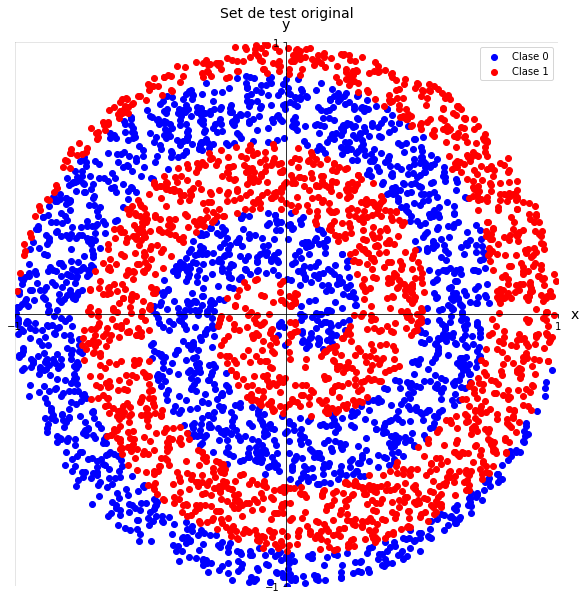

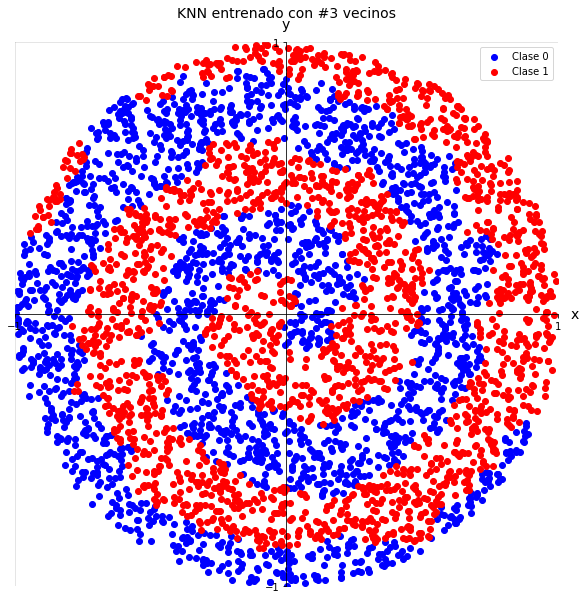

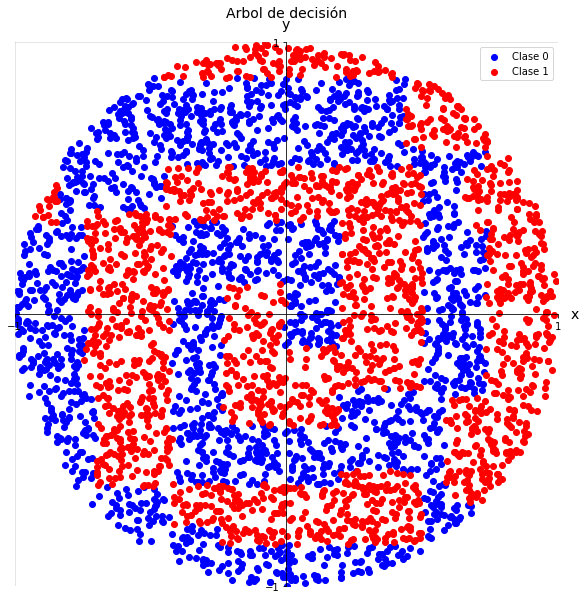

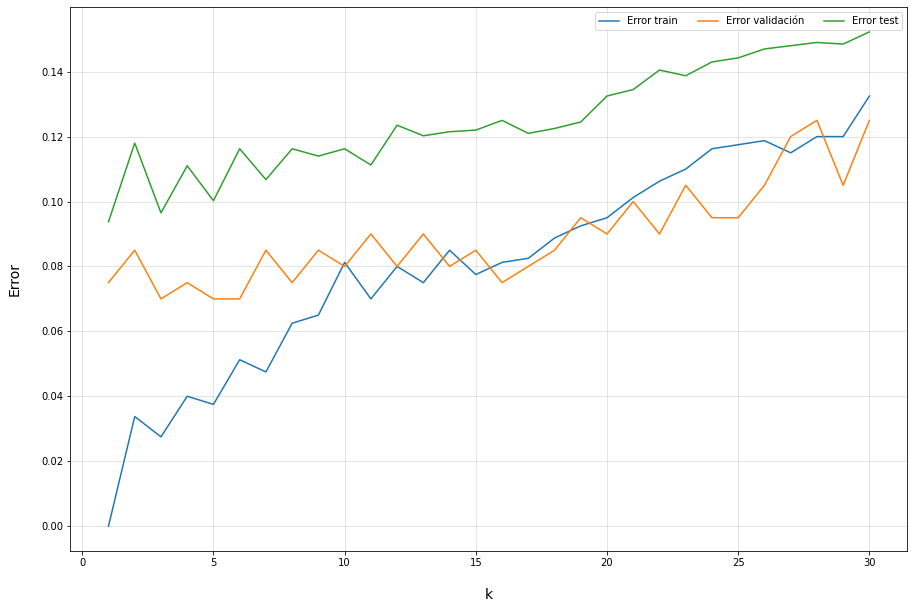

In [6]:
ej1('tp4/c_0')

Para la clasificación de datos sin ruido, se puede ver que el KNN dibuja mucho mejor el espiral comparado con el árbol de decisión. Acorde a esto, los errores parecen ser bastante chicos.  

Con ruido


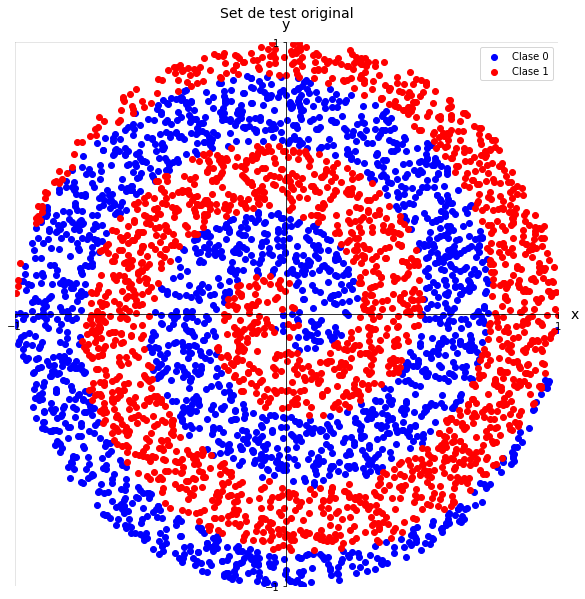

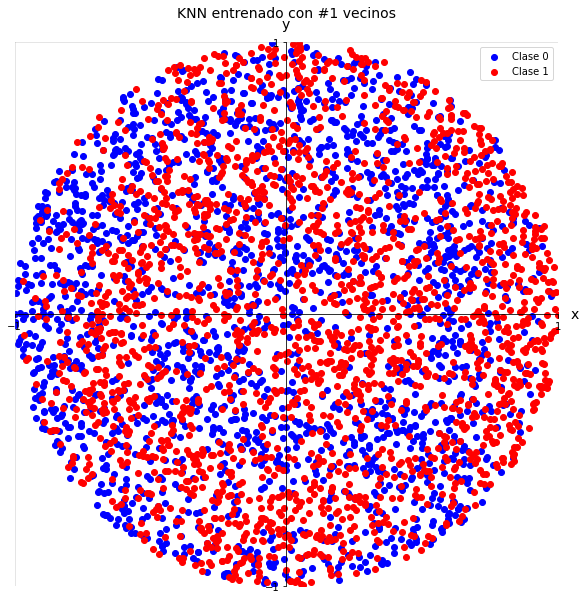

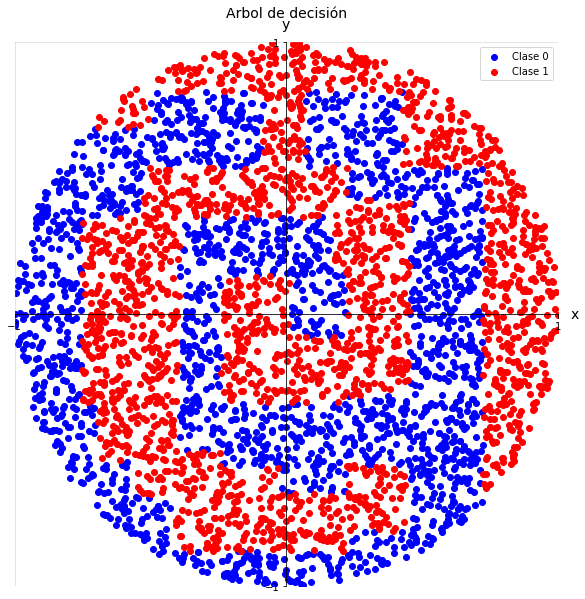

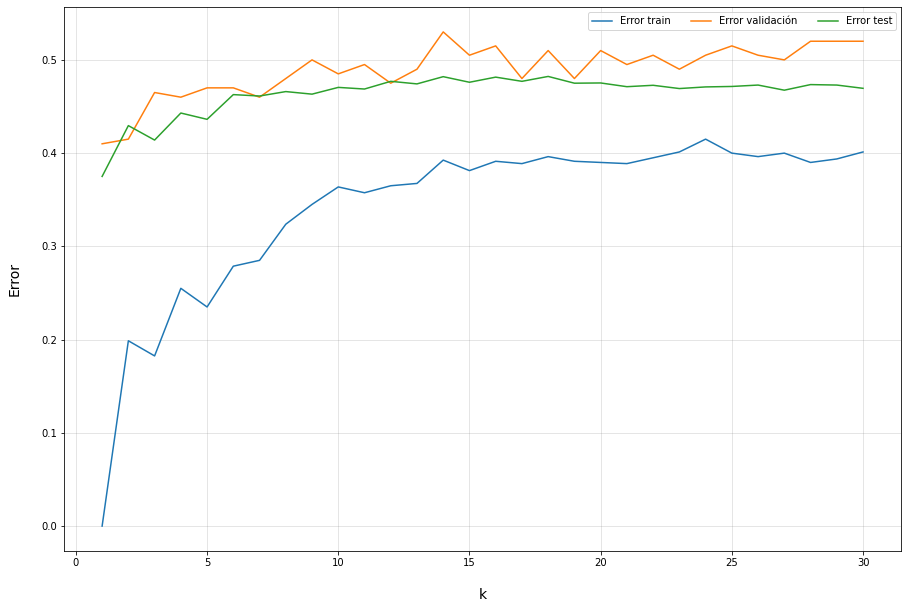

In [7]:
ej1('tp4/c_2', con_ruido=True)

Para los datos con ruido, se puede notar que el clasificador falla notablemente; no pudo siquiera dibujar alguna curva correctamente. Como se vio en la teoría, la introducción de ruido en el dataset afecta sensiblemente al clasificador si "opaca" a los datos útiles. En este caso, tenemos dos datos útiles y dos inútiles y esto hace que el peso obtenido ofusque la toma de decisión fácilmente.

---

b) Dimensionalidad: Repita el punto 4 del Práctico 1, usando k-nn. Utilice dos valores de k: el número de vecinos que se obtiene como mínimo de validación, y 1 vecino. Genere una gráfica incluyendo también los resultados de redes, árboles y naive-Bayes con Gaussianas.

Práctico 1. 4. Dimensionalidad:
 - Genere datasets con C = 0.78, n = 250 para el conjunto de entrenamiento y n = 10000 para el de test, variando esta vez el valor de d según la siguiente lista: 2, 4, 8, 16, 32. 
 - Para cada valor de d cree 20 conjuntos distintos de entrenamiento, y uno solo de test. 
 - Genere una gráfica del train y test error en función de d para el problema "paralelo" y el "diagonal" (todos en la misma gráfica). Discuta los resultados.

In [4]:
ej1_error_data = []

def calcular_error(y_df, predict_df, n, nombre, generador):
  acc_train = accuracy_score(y_df, predict_df)
  ej1_error_data.append([1-acc_train, n, nombre + " " + generador])

def entrenar_d(k, d, df_test, generador):
  if generador == 'diagonal':
    df_train = GeneradorDFDiagonal(C=0.78, d=d, n=250).generar_clase()
  else:
    df_train = GeneradorDFParalelo(C=0.78, d=d, n=250).generar_clase()

  X_train, y_train = df_train[list(range(d))], df_train['Clase']
  X_test, y_test = df_test[list(range(d))], df_test['Clase']

  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  df_train_entrenado = knn.predict(X_train)
  df_test_entrenado = knn.predict(X_test)

  calcular_error(y_train, df_train_entrenado, d, f"KNN, k = {k} - Train", generador)
  calcular_error(y_test, df_test_entrenado, d, f"KNN, k = {k} - Test", generador)


def ej2():
  d_valores = [2, 4, 8, 16, 32]

  for d in d_valores:
    df_test_diag = GeneradorDFDiagonal(C=0.78, d=d, n=10000).generar_clase()
    df_test_paral = GeneradorDFParalelo(C=0.78, d=d, n=10000).generar_clase()
    for k in [1, 3]:
      for i in range(20):
        entrenar_d(k, d, df_test_diag, 'diagonal')
        entrenar_d(k, d, df_test_paral, 'paralelo')
  
  return pd.DataFrame(ej1_error_data, columns=['Error', 'd', 'Clase'])

In [9]:
knn_errores = ej2()

In [10]:
knn_errores.to_csv("datasets/ej2_errores_knn.csv", index = False)
# print(knn_errores)

In [5]:
def graph_errores_ej2(error_df: pd.DataFrame, referencia):
  _, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()

    switch={
      "KNN, k = 1 - Train paralelo": "solid",
      "KNN, k = 1 - Test paralelo": "solid",
      "KNN, k = 1 - Train diagonal": "solid",
      "KNN, k = 1 - Test diagonal": "solid",
      "KNN, k = 3 - Train paralelo": "solid",
      "KNN, k = 3 - Test paralelo": "solid",
      "KNN, k = 3 - Train diagonal": "solid",
      "KNN, k = 3 - Test diagonal": "solid",
    }
    
    plt.plot(df[referencia], df['Error'], linestyle=switch.get(c, "dashdot"))

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)

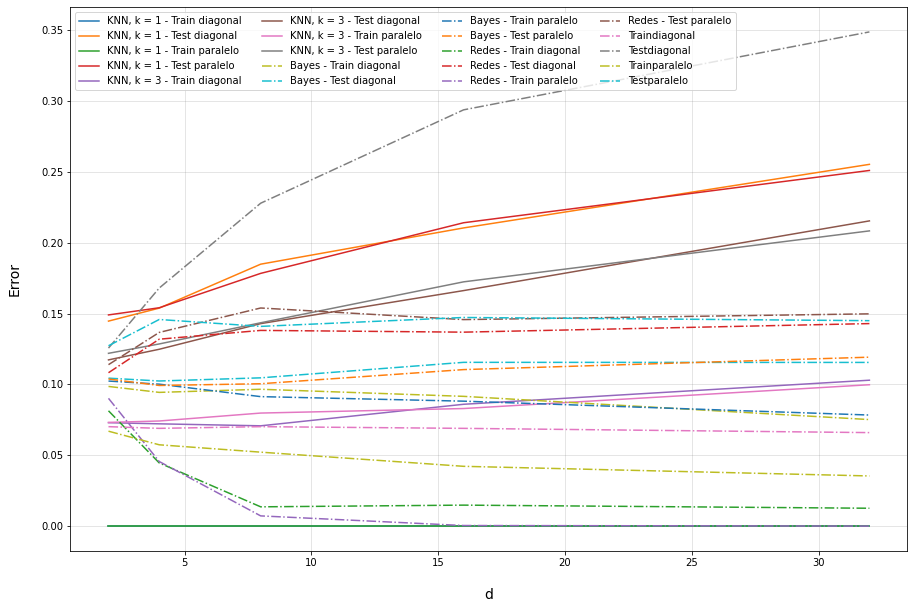

In [12]:
knn_errores = pd.read_csv("datasets/ej2_errores_knn.csv")
errores_redes = pd.read_csv("datasets/ej5_errores_redes.csv")
errores_arboles = pd.read_csv("datasets/ej5_errores_arboles.csv")
errores_bayes = pd.read_csv("datasets/ej1_errores_bayes.csv")

ej2_errores = pd.concat([knn_errores, errores_bayes, errores_redes, errores_arboles])
graph_errores_ej2(ej2_errores, 'd')

Se puede ver que el modelo de k-vecinos es uno de los peores para resolver este problema, incluso el error crece bastante junto con la dimensionalidad. También se vio en la teoría que la dimensionalidad afecta al modelo, ya que los vecinos estarían más "distantes" entre sí. No obstante, para k = 3, los errores obtenidos son bastante menores a k = 1, en donde incluso se produjo sobreajuste.

---

c) Distancias pesadas: Aplique la versión con votación pesada por distancia (inversa) con dos valores de k: k=50 o un valor de k optimizado con un conjunto de validación. Aplique las dos versiones al problema de la dimensionalidad. Tomando d=32, genere las curvas de error de entrenamiento, validación y test y coméntelas. Genere también nuevas curvas de error vs dimensiones para los dos clasificadores (k fijo y k óptimo) y compárelas con las del clasificador con peso uniforme del punto anterior (también con k=1 y con k óptimo).

In [4]:
def train_val(df_train_val, d):
  X_train_val, y_train_val = df_train_val[list(range(d))], df_train_val['Clase']
  return train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

def entrenar_d3a(k, d, df_test, generador):
  if generador == 'diagonal':
    df_train_val = GeneradorDFDiagonal(C=0.78, d=d, n=250).generar_clase()
  else:
    df_train_val = GeneradorDFParalelo(C=0.78, d=d, n=250).generar_clase()

  X_train, X_val, y_train, y_val = train_val(df_train_val, d)
  X_test, y_test = df_test[list(range(d))], df_test['Clase']
  
  if k != None:
    k_values = [k]
  else:
    k_values = range(1, 51)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar('ej3', k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  errores = []

  if k != None:
    errores.append([error_train_data[0], k, f"Error train {generador}"])
    errores.append([error_val_data[0], k, f"Error validación {generador}"])
    errores.append([error_test_data[0], k, f"Error test {generador}"])
  else:
    for i in k_values:
      errores.append([error_train_data[i-1], i, f"Error train {generador}"])
      errores.append([error_val_data[i-1], i, f"Error validación {generador}"])
      errores.append([error_test_data[i-1], i, f"Error test {generador}"])

  return errores


def ej3a(k = None):
  d_valores = [32]

  for d in d_valores:
    df_test_diag = GeneradorDFDiagonal(C=0.78, d=d, n=10000).generar_clase()
    df_test_paral = GeneradorDFParalelo(C=0.78, d=d, n=10000).generar_clase()
    #for k in range(1, 51):
    #for i in range(20):
    err_diag = entrenar_d3a(k, d, df_test_diag, 'diagonal')
    err_paral = entrenar_d3a(k, d, df_test_paral, 'paralelo')
  
  return pd.DataFrame(err_diag + err_paral, columns=['Error', 'k', 'Clase'])
  

In [14]:
errores_ej3a_kopt = ej3a()
errores_ej3a_kfijo = ej3a(k=50)

In [15]:
# print(errores_ej3a_kfijo)
# print(errores_ej3a_kopt)

In [5]:
def graph_errores_ej3a(error_df: pd.DataFrame, referencia):
  _, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()

    switch={
      "Error test paralelo": "solid",
      "Error test diagonal": "solid",
    }
    
    plt.plot(df[referencia], df['Error'], linestyle=switch.get(c, "dashdot"))

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)

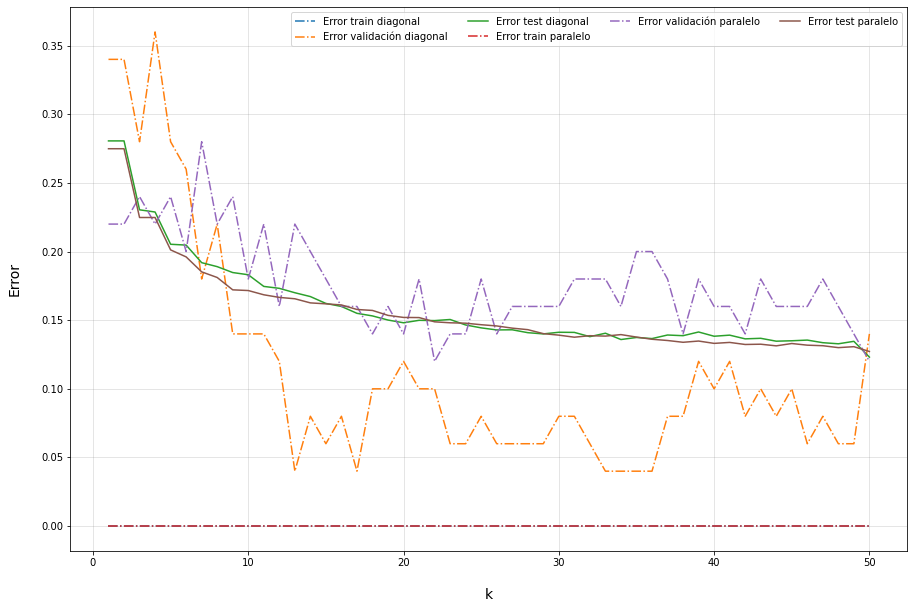

In [17]:
errores_ej3a = pd.concat([errores_ej3a_kopt, errores_ej3a_kfijo])
graph_errores_ej3a(errores_ej3a, 'k')

Se pueden ver resultados similares para las curvas de test y validación para ambos datasets generados. En los dos casos, resulta el k óptimo mejor que k = 50. A pesar de tener dimensionalidad alta (d = 32), el error se mantiene relativamente bajo e incluso disminuye a medida que crece el k.

In [6]:
errores_ej3b_kfijo = []
errores_ej3b_kopt = []

def entrenar_d3b(k, d, df_test, generador):
  if generador == 'diagonal':
    df_train_val = GeneradorDFDiagonal(C=0.78, d=d, n=250).generar_clase()
  else:
    df_train_val = GeneradorDFParalelo(C=0.78, d=d, n=250).generar_clase()

  X_train, X_val, y_train, y_val = train_val(df_train_val, d)
  X_test, y_test = df_test[list(range(d))], df_test['Clase']
  
  if k != None:
    k_values = [k]
  else:
    k_values = range(1, 51)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar('ej3', k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  if k != None:
    errores_ej3b_kfijo.append([error_train_data[0], d, f"Error train {generador}"])
    errores_ej3b_kfijo.append([error_val_data[0], d, f"Error validación {generador}"])
    errores_ej3b_kfijo.append([error_test_data[0], d, f"Error test {generador}"])
  else:
    for i in k_values:
      errores_ej3b_kopt.append([error_train_data[i-1], d, f"Error train {generador}"])
      errores_ej3b_kopt.append([error_val_data[i-1], d, f"Error validación {generador}"])
      errores_ej3b_kopt.append([error_test_data[i-1], d, f"Error test {generador}"])

def ej3b():
  d_valores = [2, 4, 8, 16, 32]

  for d in d_valores:
    df_test_diag = GeneradorDFDiagonal(C=0.78, d=d, n=10000).generar_clase()
    df_test_paral = GeneradorDFParalelo(C=0.78, d=d, n=10000).generar_clase()

    for i in range(20):
      entrenar_d3b(None, d, df_test_diag, 'diagonal')
      entrenar_d3b(None, d, df_test_paral, 'paralelo')
      entrenar_d3b(50, d, df_test_diag, 'diagonal')
      entrenar_d3b(50, d, df_test_paral, 'paralelo')
  
  df_errores_kfijo = pd.DataFrame(errores_ej3b_kfijo, columns=['Error', 'd', 'Clase'])
  df_errores_kopt = pd.DataFrame(errores_ej3b_kopt, columns=['Error', 'd', 'Clase'])
  return df_errores_kfijo, df_errores_kopt
  

In [9]:
df_errores_kfijo, df_errores_kopt = ej3b()

In [ ]:
# print(df_errores_kfijo)
# print(df_errores_kopt)

Gráfico con k = 50
Gráfico con k óptimo


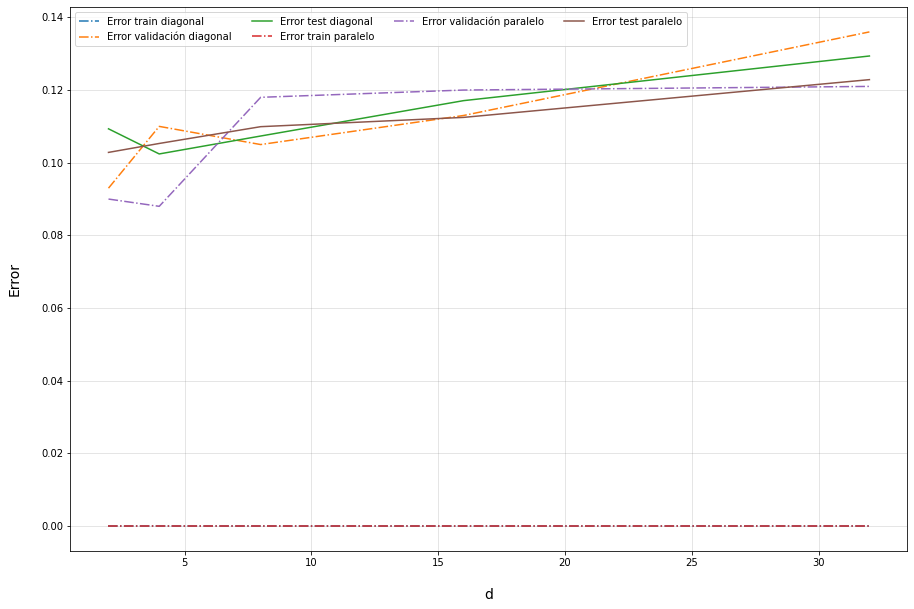

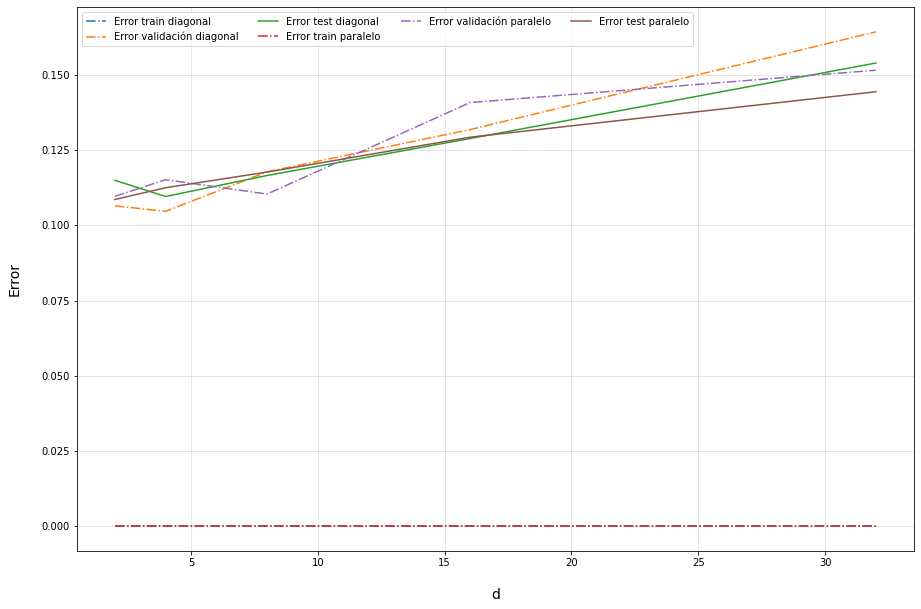

In [ ]:
# errores_ej3b = pd.concat([, df_errores_kopt])
print("Gráfico con k = 50")
graph_errores_ej3a(df_errores_kfijo, 'd')
print("Gráfico con k óptimo")
graph_errores_ej3a(df_errores_kopt, 'd')

No parece que haya comportamiento distinto entre los dos casos. Para el k fijo, los errores de validación son apenas menores que con el k óptimo cuando la dimensionalidad es muy grande.

---

d) Regresión con k_nn: Prepare código para usar k-nn en regresión con pesos uniformes y con pesado inverso a la distancia, como se describió en la teoría. Aplique las dos versiones al problema de Sunspots (SSP) y al problema de Ikeda, y compare los resultados con los obtenidos con ANN.

In [23]:
def ej4a_dfs(filename):
  names = list(range(12)) + ['Value']
  dos_e_dfs = GeneradorDFCSV(filename, custom=True, names=names)
  df_train_val = dos_e_dfs.df_data
  X_train_val, y_train_val = df_train_val[names[:-1]], df_train_val['Value']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[names[:-1]], df_test['Value']

  return X_train, y_train, X_test, y_test, X_val, y_val, df_test

def ej4a(filename, problema):
  X_train, y_train, X_test, y_test, X_val, y_val, df_test = ej4a_dfs(filename)
  k_values = range(1, 51)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar(problema, k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  errores = []
  for i in k_values:
    errores.append([error_train_data[i-1], i, "Error train"])
    errores.append([error_val_data[i-1], i, "Error validación"])
    errores.append([error_test_data[i-1], i, "Error test"])

  errores_df = pd.DataFrame(errores, columns=['Error', 'k', 'Clase'])

  return error_test_data, best_k, errores_df



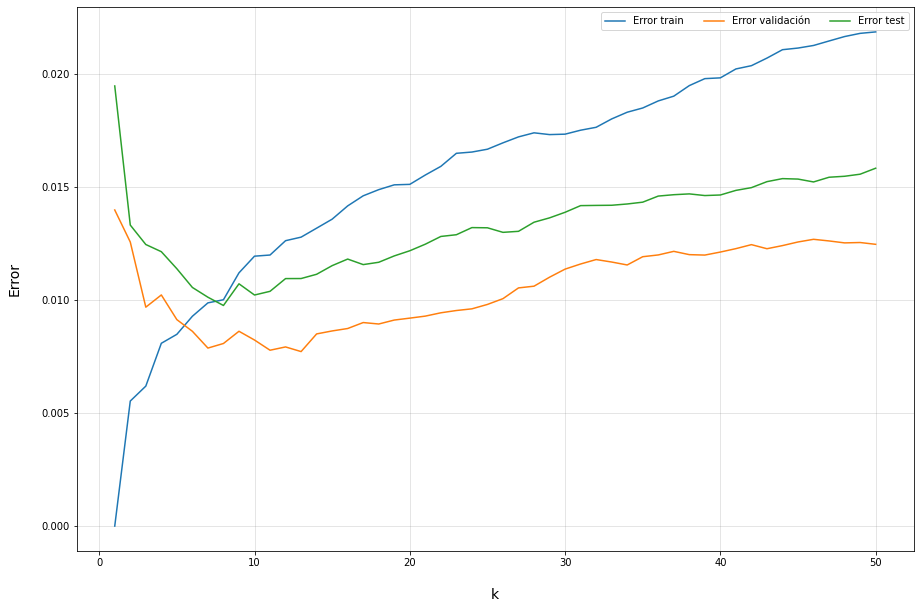

In [24]:
error_test_data_unif, best_k_unif, errores_unif_df = ej4a('ssp', 'ej4_unif')
graph_errores(errores_unif_df, 'k')

In [25]:
print(f"Mejor k: {best_k_unif} con error {error_test_data_unif[best_k_unif - 1]}")

Mejor k: 13 con error 0.010960752115246363


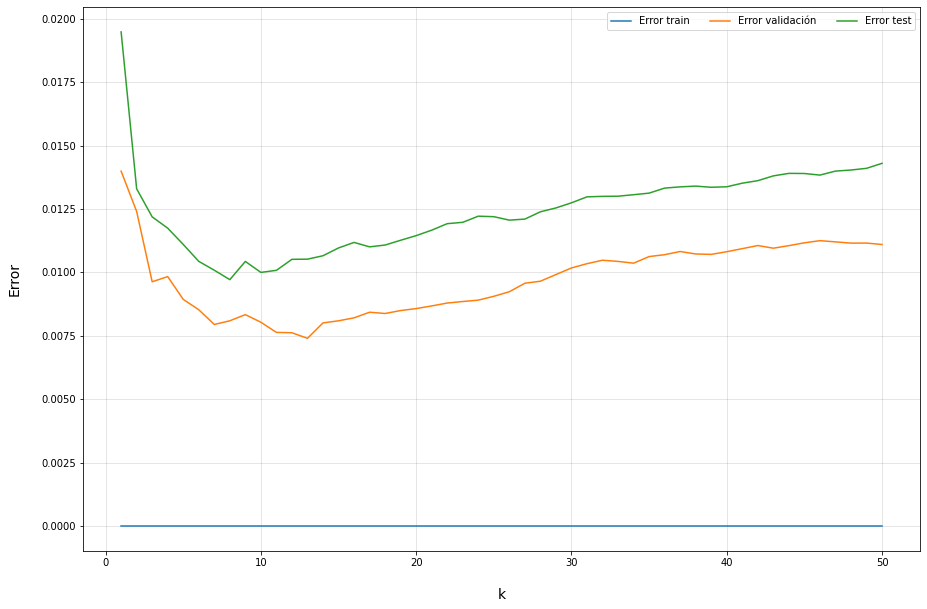

In [27]:
error_test_data_inv, best_k_inv, errores_inv_df = ej4a('ssp', 'ej4_inv')
graph_errores(errores_inv_df, 'k')

In [28]:
print(f"Mejor k: {best_k_inv} con error {error_test_data_inv[best_k_inv - 1]}")

Mejor k: 13 con error 0.01052545706694871


Cito del TP de redes neuronales: 

> El mejor gamma de todos los aplicados fue 10^-6, cuyo **error de test fue 0.005389** y de train fue 0.004751. Siendo valores tan estrechos, no parecería que hubo sobreajuste. En general, para ninguno de los valores de gamma se podría observar que hubo sobreajuste.

Para este dataset, el modelo de redes neuronales resulta superior.

---

In [29]:
def ej4b_dfs(filename):
  names = list(range(5)) + ['Value']
  dos_e_dfs = GeneradorDFCSV(filename, custom=True, names=names, delim_whitespace=True, skipinitialspace=True)
  df_train_val = dos_e_dfs.df_data
  X_train_val, y_train_val = df_train_val[names[:-1]], df_train_val['Value']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[names[:-1]], df_test['Value']

  return X_train, y_train, X_test, y_test, X_val, y_val, df_test

def ej4b(filename, problema):
  X_train, y_train, X_test, y_test, X_val, y_val, df_test = ej4b_dfs(filename)
  k_values = range(1, 51)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar(problema, k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  errores = []
  for i in k_values:
    errores.append([error_train_data[i-1], i, "Error train"])
    errores.append([error_val_data[i-1], i, "Error validación"])
    errores.append([error_test_data[i-1], i, "Error test"])

  errores_df = pd.DataFrame(errores, columns=['Error', 'r', 'Clase'])

  return error_test_data, best_k, errores_df

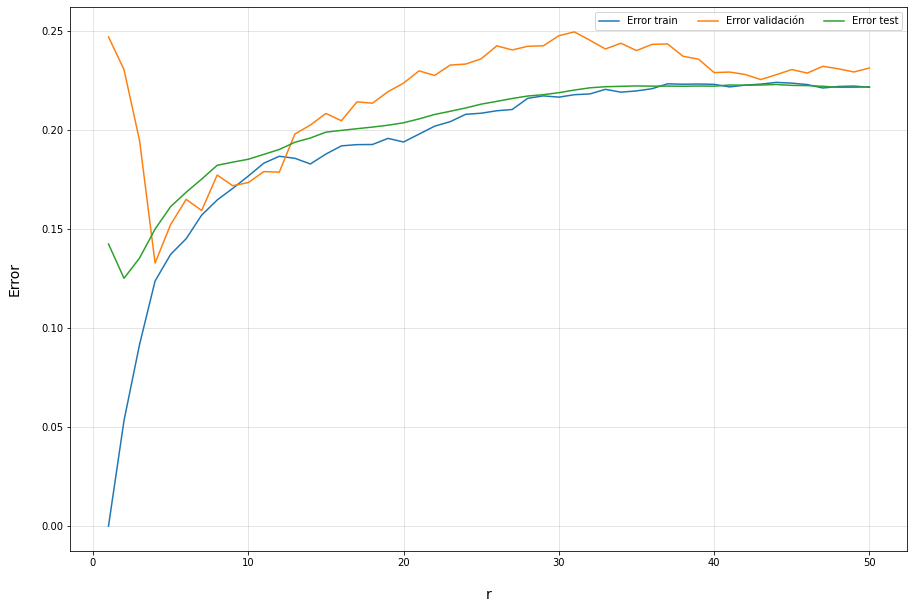

In [31]:
error_test_data_unif, best_k_unif, errores_unif_df = ej4b('ikeda', 'ej4_unif')
graph_errores(errores_unif_df, 'r')

In [32]:
print(f"Mejor k: {best_k_unif} con error {error_test_data_unif[best_k_unif - 1]}")

Mejor k: 4 con error 0.15002023454779273


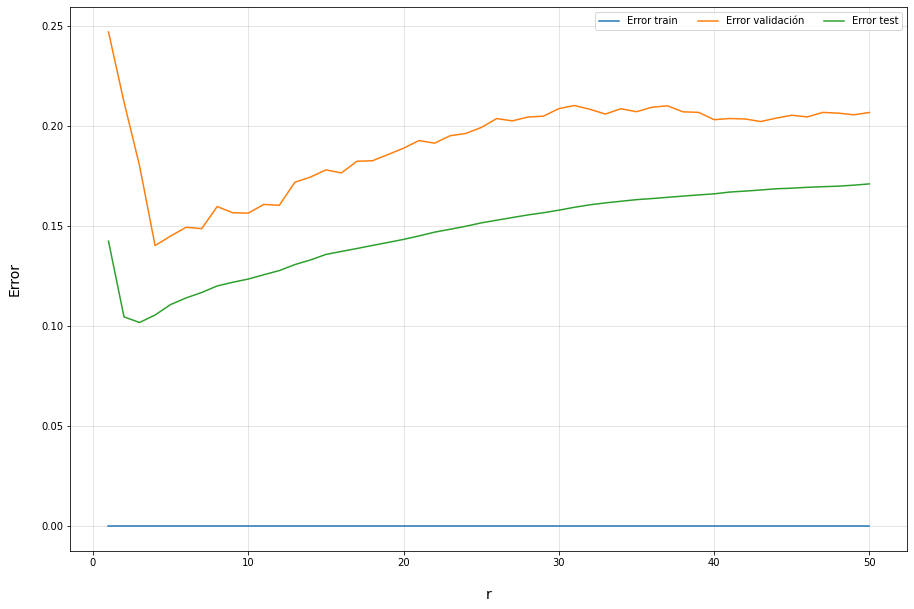

In [33]:
error_test_data_inv, best_k_inv, errores_inv_df = ej4b('ikeda', 'ej4_inv')
graph_errores(errores_inv_df, 'r')

In [34]:
print(f"Mejor k: {best_k_inv} con error {error_test_data_inv[best_k_inv - 1]}")

Mejor k: 4 con error 0.10554935808987567


Gráfico de errores del dataset Ikeda para el TP de redes.

![](tp4_ikeda.png)

Comparando las curvas de error de test, se puede ver que para este dataset también es superior el modelo de redes neuronales. Quizá la comparación sea incorrecta, ya que para redes se separó (con random state nulo) un 25% para validación mientras que para KNN se usó un 20% y con random state positivo.